In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
input_path = '../../input'

In [29]:
col_names = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
    'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]
feature_names = col_names[1:]
df = pd.read_csv(f'{input_path}/agaricus-lepiota.data', names=['edibility']+col_names)

In [30]:
df.head()

,edibility,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [31]:
df.isna().sum()

edibility                   0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [32]:
from sklearn.model_selection import train_test_split

_, test_idxs = train_test_split(df.index, test_size=0.2, stratify=df['edibility'], random_state=42)
test_mask = df.index.isin(test_idxs)

In [33]:
df['edibility'].value_counts()

e    4208
p    3916
Name: edibility, dtype: int64

In [34]:
df_train = df[~test_mask]
df_test = df[test_mask]

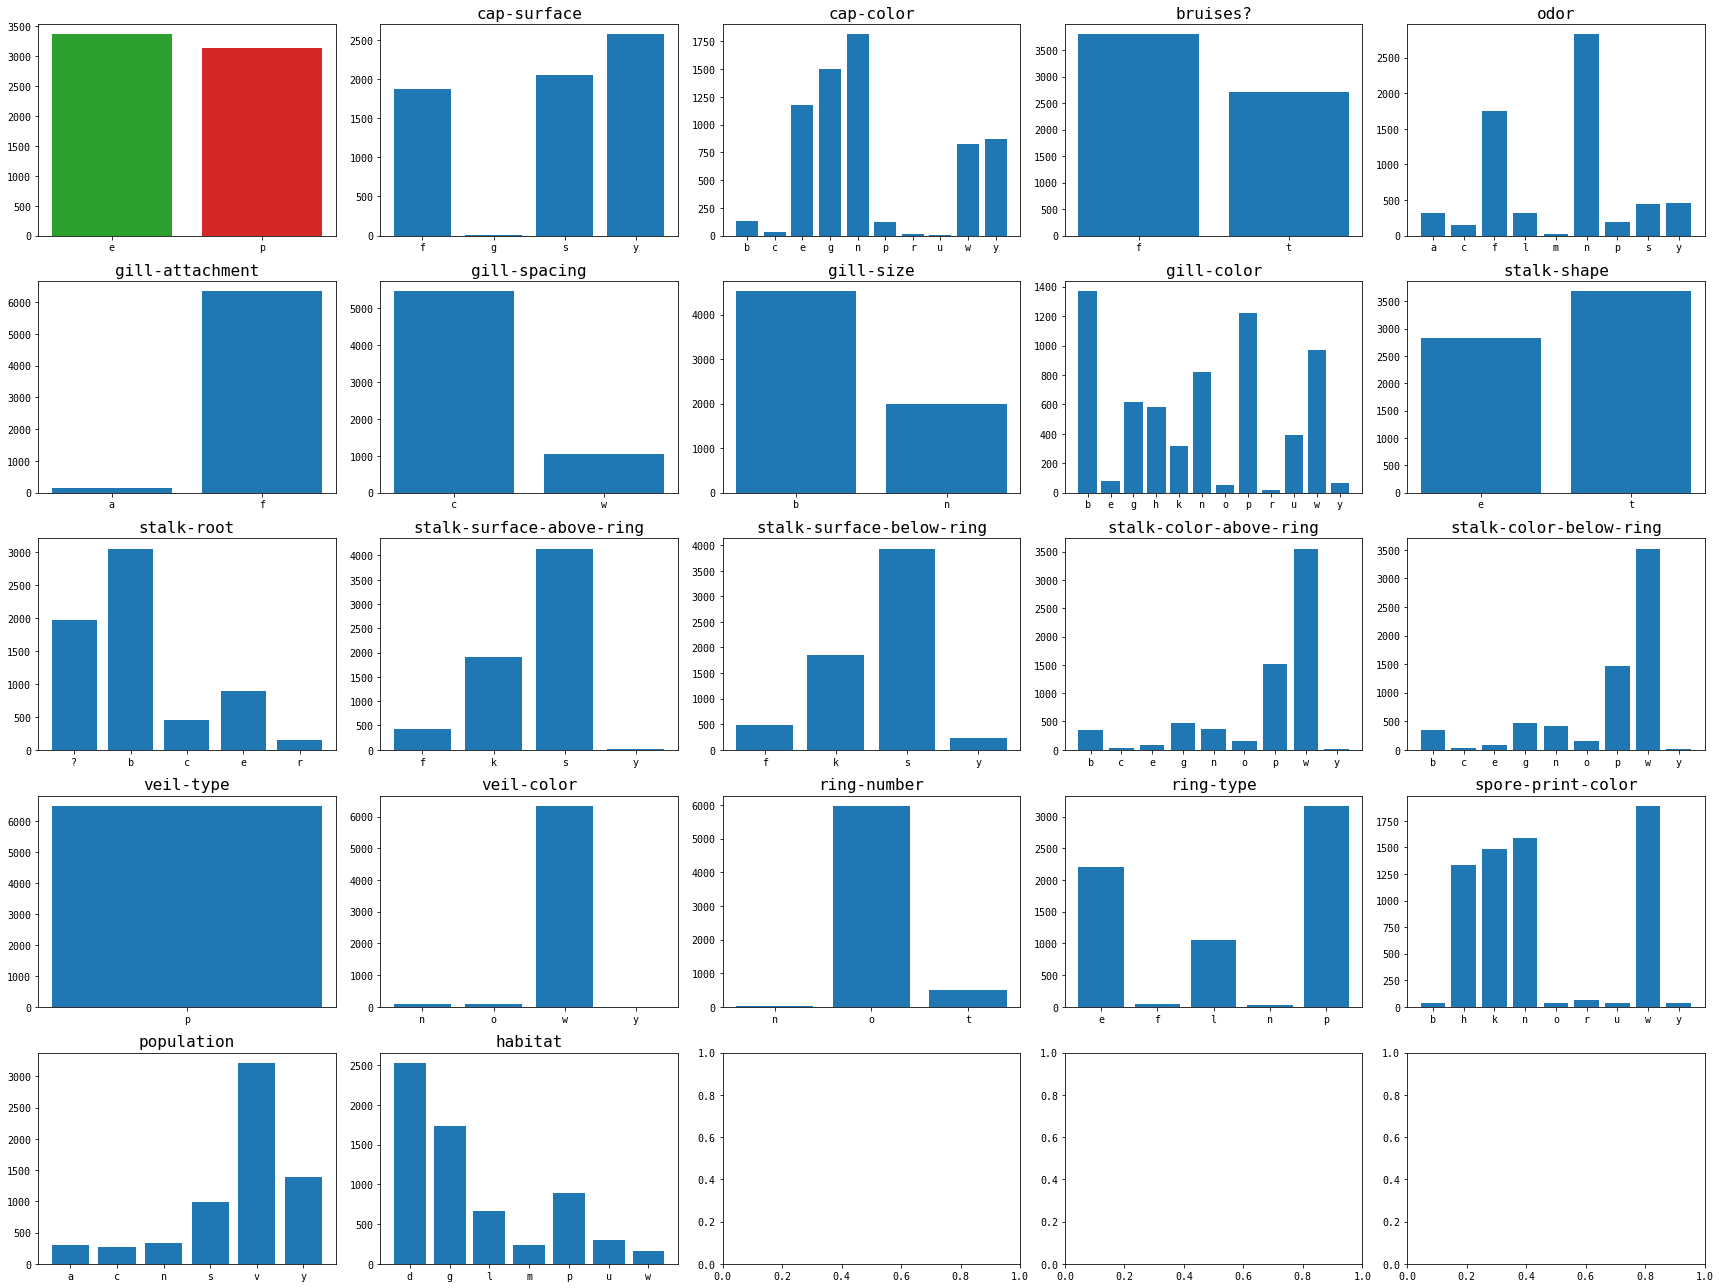

In [35]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
ax = axs[0]
ax.bar(['e', 'p'], [(df_train['edibility'] == 'e').sum(), 0], color='C2')
ax.bar(['e', 'p'], [0, (df_train['edibility'] == 'p').sum()], color='C3')
for i in range(1, 22):
    ax = axs[i]
    ser = df_train[col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C{3*int(i==0)}')
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()

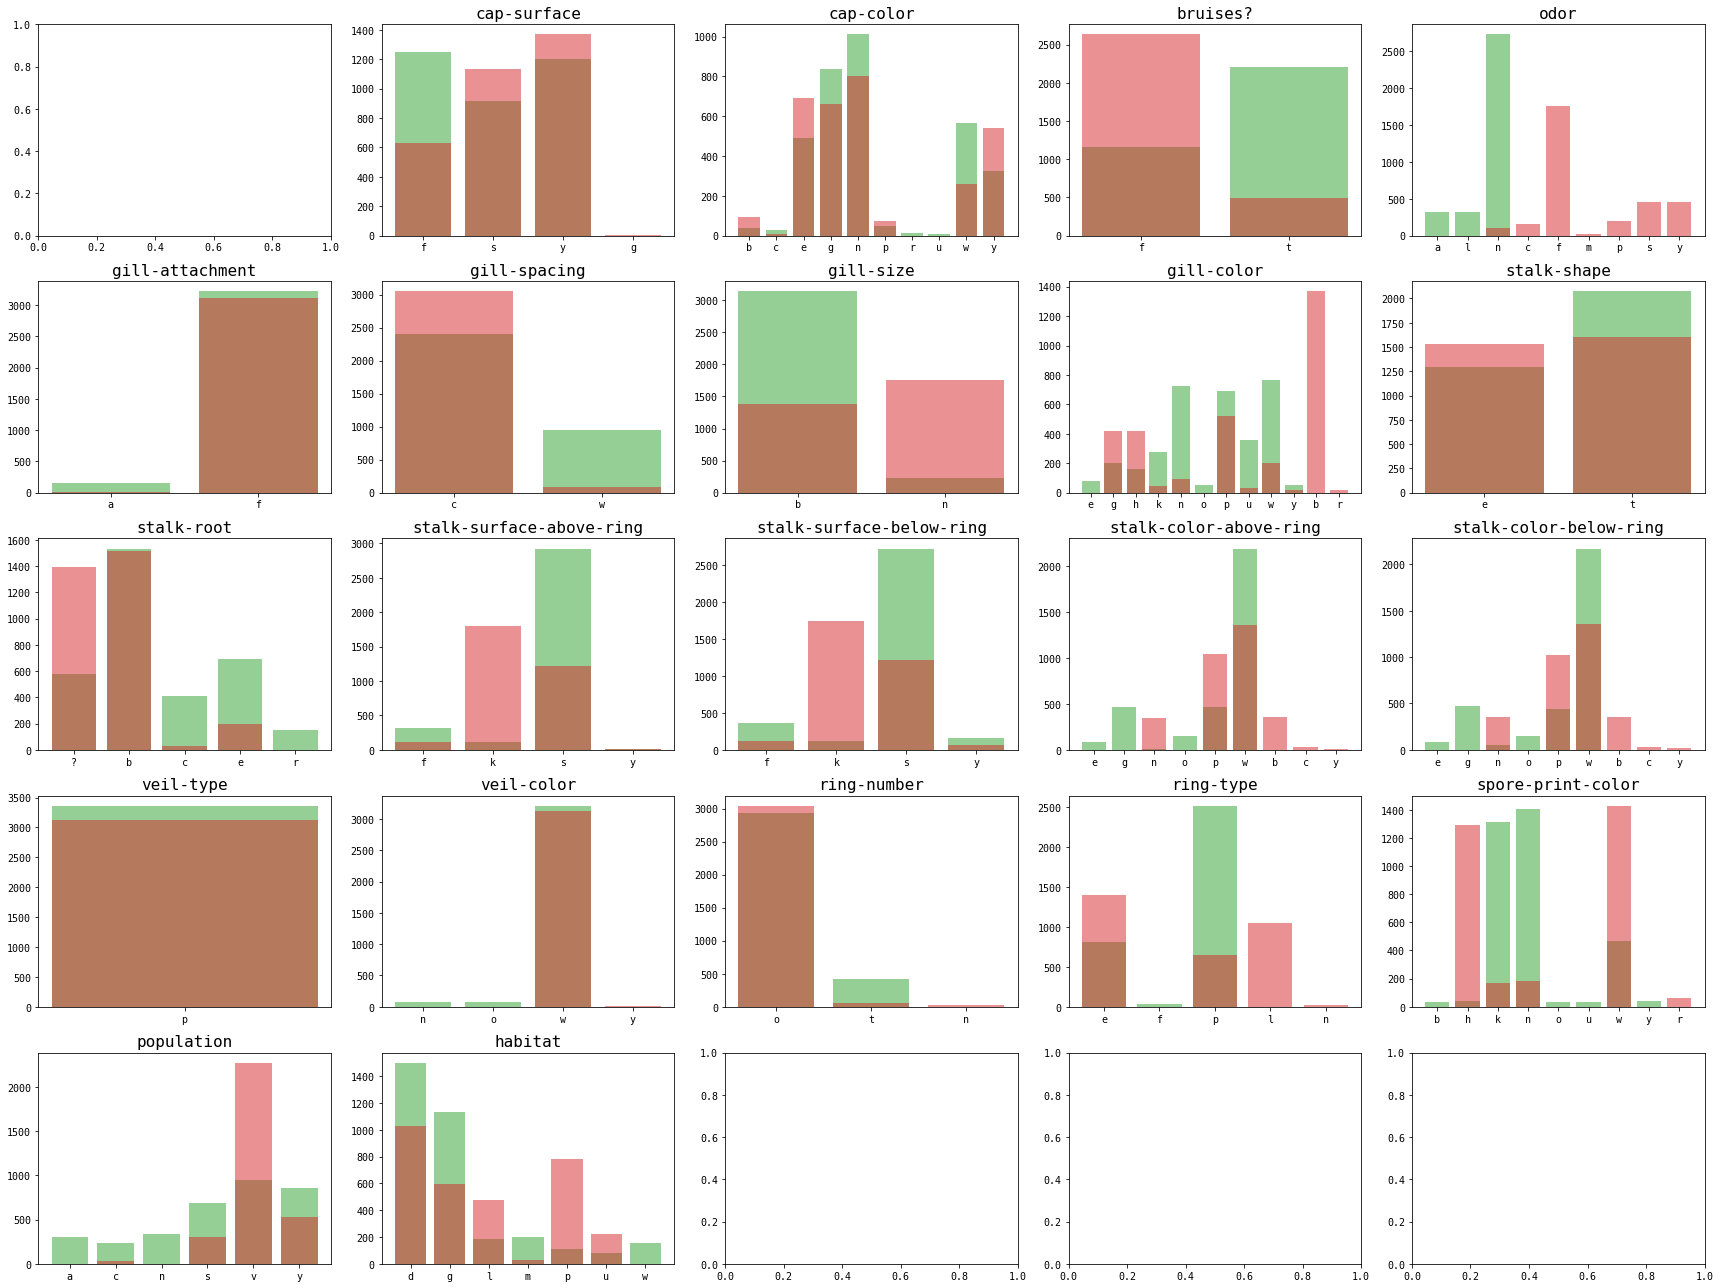

In [36]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
for i in range(1, 22):
    ax = axs[i]
    ser = df_train.loc[df_train['edibility'] == 'e', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C2', alpha=0.5)

    ser = df_train.loc[df_train['edibility'] == 'p', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C3', alpha=0.5)
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()

In [37]:
from scipy.stats import chi2_contingency
import itertools

cramer_v = np.zeros((len(col_names), len(col_names)))

for name1, name2 in itertools.product(col_names, col_names):
    if name1 == 'veil-type' or name2 == 'veil-type':
        continue
    chi2, _, _, _ = chi2_contingency(pd.crosstab(df_train[name1], df_train[name2]))
    v = np.sqrt(chi2 / (min(df_train[name1].nunique(), df_train[name2].nunique())-1) / df_train.shape[0])
    cramer_v[col_names.index(name1), col_names.index(name2)] = v
    cramer_v[col_names.index(name2), col_names.index(name1)] = v

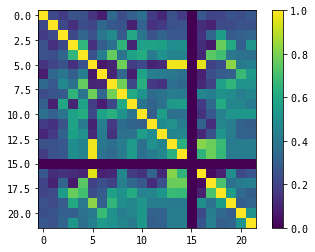

In [38]:
img = plt.imshow(cramer_v)
plt.colorbar(img)

2nd

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        sparse=False
    ),
    LogisticRegression(
        max_iter=1000,
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

0.9998461301738729
0.9993846153846154


In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


X_train, X_test = df_train[col_names], df_test[col_names]
y_train, y_test = df_train['edibility'], df_test['edibility']

model = make_pipeline(
    OneHotEncoder(
        sparse=False
    ),
    SVC(
        random_state=42
    )
)
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

1.0
1.0
